In [1]:
import pymde

import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
# load the cooccurrence matrix from compressed npz file
# cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix.npz')['arr_0']
# cooccurrence_matrix.shape

cooccurrence_matrix = np.load('./work/data/cooccurrence_matrix_wextra.npy')

In [4]:
cooccurrence_matrix[0]

array([0.00000000e+00, 6.03813686e+08, 7.56560427e+07, ...,
       2.87163000e+03, 1.82065000e+03, 3.28739000e+03])

In [6]:
# clear out any self-edges in the cooccurrence matrix
# TODO: this shouldn't be necessary... idk how they got there
np.fill_diagonal(cooccurrence_matrix, 0)

In [7]:
import scipy.sparse as sp

# Build sparse matrix from the dense cooccurrence matrix, dropping the zero entries
cooccurrence_matrix_sparse = sp.csr_matrix(cooccurrence_matrix)
cooccurrence_graph = pymde.preprocess.Graph(cooccurrence_matrix_sparse)

In [8]:
dissimilarities = 1. / torch.log(cooccurrence_graph.weights + 1)

dissimilarity_graph = pymde.Graph.from_edges(cooccurrence_graph.edges, dissimilarities)
(dissimilarities.min(), dissimilarities.max())

(tensor(0.0469), tensor(4.4814))

In [9]:
shortest_path_graph = pymde.preprocess.graph.shortest_paths(dissimilarity_graph, verbose=True, n_workers=28)

Jul 21 12:17:53 AM: Computing shortest path distances (retaining 100.00 percent with max_distance=None) ...
Jul 21 12:17:54 AM: Graph is weighted ... using slow path.
Jul 21 12:18:37 AM: processed node 1/13647
Jul 21 12:22:42 AM: processed node 1365/13647
Jul 21 12:26:46 AM: processed node 2729/13647
Jul 21 12:30:52 AM: processed node 4093/13647
Jul 21 12:34:59 AM: processed node 5457/13647
Jul 21 12:39:05 AM: processed node 6821/13647
Jul 21 12:43:11 AM: processed node 8185/13647
Jul 21 12:47:29 AM: processed node 9549/13647
Jul 21 12:51:49 AM: processed node 10913/13647
Jul 21 12:56:02 AM: processed node 12277/13647
Jul 21 01:00:22 AM: processed node 13641/13647


In [23]:
n_neighbors = 100
embedding_dim = 4

mde = pymde.preserve_neighbors(shortest_path_graph, embedding_dim=embedding_dim, verbose=True, max_distance=10000, n_neighbors=n_neighbors)

Jul 21 01:05:23 AM: Computing 100-nearest neighbors, with max_distance=10000
Jul 21 01:05:32 AM: Computing quadratic initialization.


In [24]:
X = mde.embed(verbose=True,)

Jul 21 01:05:40 AM: Fitting a centered embedding into R^4, for a graph with 13647 items and 2660990 edges.
Jul 21 01:05:40 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Jul 21 01:05:40 AM: iteration 000 | distortion 0.546823 | residual norm 0.00643584 | step length 55.05 | percent change 0.15164
Jul 21 01:05:44 AM: iteration 030 | distortion 0.455472 | residual norm 0.000924714 | step length 1 | percent change 0.969396
Jul 21 01:05:48 AM: iteration 060 | distortion 0.445636 | residual norm 0.000471866 | step length 1 | percent change 0.724168
Jul 21 01:05:52 AM: iteration 090 | distortion 0.442145 | residual norm 0.000436508 | step length 1 | percent change 0.910692
Jul 21 01:05:55 AM: iteration 120 | distortion 0.438353 | residual norm 0.000285038 | step length 1 | percent change 0.558915
Jul 21 01:05:59 AM: iteration 150 | distortion 0.435994 | residual norm 0.000288117 | step length 1 | percent change 0.594001
Jul 21 01:06:03 AM: iteration 180 | distortion

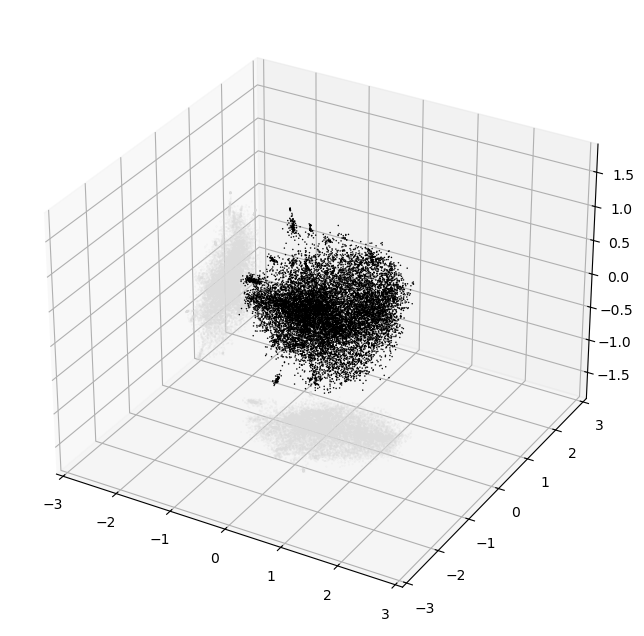

In [25]:
mde.plot(colors=['black'])
# plot from x=-3 to 3
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [27]:
# export in w2v format
fname = f'./work/data/pymde_{embedding_dim}d_{n_neighbors}n.w2v'
with open(fname, 'wt') as f:
    # write header
    f.write('{} {}\n'.format(len(X), mde.embedding_dim))
    for i in range(len(X)):
        row = X[i].tolist()
        f.write('{} {}\n'.format(i, ' '.join(map(str, row))))
fname

'./work/data/pymde_4d_100n.w2v'